# Task 2 - Semantic Role Labeling

Name: Bhavna Balakrishnan <br>
Student ID: 33954437

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from itertools import chain
import pandas as pd
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn_crfsuite import metrics
from sklearn_crfsuite.utils import flatten
from sklearn import metrics as skmetrics
import os
from collections import Counter
import numpy as np
import sklearn_crfsuite
import pandas as pd

Import all necessary libraries

## 1. Explore the Datasets

In [2]:
# Function to parse CoNLL-U format data from a list of file paths
def parse_conllu(file_paths):
    all_sentences = []
    all_labels = []
    
    for file_path in file_paths:
        sentences = []
        labels = []
        sentence = []
        label = []
        
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('#') or line.strip() == "":
                    # Only append if sentence and label lengths match
                    if sentence and label and len(sentence) == len(label):
                        sentences.append(sentence)
                        labels.append(label)
                    sentence = []
                    label = []
                else:
                    parts = line.strip().split('\t')
                    if len(parts) >= 12:
                        lemma = parts[1]
                        pos = parts[3]
                        head = parts[6]
                        deprel = parts[7]
                        predicate = parts[10]
                        srl_label = parts[11]
                        sentence.append((lemma, pos, head, deprel, predicate))
                        label.append(srl_label)
        
        # Append last sentence and label if they match
        if sentence and label and len(sentence) == len(label):
            sentences.append(sentence)
            labels.append(label)

        # Add to the main lists
        all_sentences.extend(sentences)
        all_labels.extend(labels)
    
    return all_sentences, all_labels

# List of file paths to read
file_paths = [
    'en_ewt-up-train.conllu',
    'en_ewt-up-dev.conllu',
    'en_ewt-up-test-no-labels.conllu'
]

# Parse the files
X, y = parse_conllu(file_paths)

# Check if the lengths of all sentences match with labels
def check_consistency(X, y):
    for i in range(len(X)):
        if len(X[i]) != len(y[i]):
            print(f"Mismatch in sentence {i}: X length = {len(X[i])}, y length = {len(y[i])}")

# Run consistency check
check_consistency(X, y)

# --- Check for NaN, Nulls, or Missing Values ---
def check_for_missing_values(X, y):
    missing_features = {
        'lemma': 0,
        'pos': 0,
        'head': 0,
        'deprel': 0,
        'predicate': 0,
        'srl_label': 0
    }
    
    # Check for missing values in sentences (X) and labels (y)
    for i, sentence in enumerate(X):
        for j, word in enumerate(sentence):
            lemma, pos, head, deprel, predicate = word
            srl_label = y[i][j]
            
            # Check if any feature is missing or equals "_"
            if lemma == "" or lemma == "_" or lemma is None:
                missing_features['lemma'] += 1
            if pos == "" or pos == "_" or pos is None:
                missing_features['pos'] += 1
            if head == "" or head == "_" or head is None:
                missing_features['head'] += 1
            if deprel == "" or deprel == "_" or deprel is None:
                missing_features['deprel'] += 1
            if predicate == "" or predicate == "_" or predicate is None:
                missing_features['predicate'] += 1
            if srl_label == "" or srl_label == "_" or srl_label is None:
                missing_features['srl_label'] += 1

    # Print the missing value statistics
    print("Missing or null values in features:")
    for feature, count in missing_features.items():
        print(f"{feature}: {count}")

# Check for NaN, nulls, or underscores in the parsed data
check_for_missing_values(X, y)

# Print the first parsed sentence and label for verification
print(f"First sentence: {X[0]}")
print(f"First labels: {y[0]}")


Missing or null values in features:
lemma: 5
pos: 0
head: 0
deprel: 0
predicate: 192954
srl_label: 208169
First sentence: [('Al', 'PROPN', '0', 'root', '_'), ('-', 'PUNCT', '1', 'punct', '_'), ('Zaman', 'PROPN', '1', 'flat', '_'), (':', 'PUNCT', '1', 'punct', '_'), ('American', 'ADJ', '6', 'amod', '_'), ('forces', 'NOUN', '7', 'nsubj', '_'), ('killed', 'VERB', '1', 'parataxis', 'kill.01'), ('Shaikh', 'PROPN', '7', 'obj', '_'), ('Abdullah', 'PROPN', '8', 'flat', '_'), ('al', 'PROPN', '8', 'flat', '_'), ('-', 'PUNCT', '8', 'punct', '_'), ('Ani', 'PROPN', '8', 'flat', '_'), (',', 'PUNCT', '8', 'punct', '_'), ('the', 'DET', '15', 'det', '_'), ('preacher', 'NOUN', '8', 'appos', '_'), ('at', 'ADP', '18', 'case', '_'), ('the', 'DET', '18', 'det', '_'), ('mosque', 'NOUN', '7', 'obl', '_'), ('in', 'ADP', '21', 'case', '_'), ('the', 'DET', '21', 'det', '_'), ('town', 'NOUN', '18', 'nmod', '_'), ('of', 'ADP', '23', 'case', '_'), ('Qaim', 'PROPN', '21', 'nmod', '_'), (',', 'PUNCT', '21', 'punct', 

## Approach

- Parsing Data (parse_conllu): Reads CoNLL-U files, extracting word features (lemma, POS, head, deprel, predicate) and semantic role labels (SRL). Ensures sentence and label lengths match before storing them in X (features) and y (labels).
- Consistency Check (check_consistency): Verifies that all sentences have corresponding labels of equal length.
- Missing Values Check (check_for_missing_values): Scans and counts missing or placeholder values (e.g., underscores) in key features (lemma, pos, head, etc.) and labels.
- Data Inspection: Prints the first parsed sentence and its labels for manual verification.

This prepares clean, validated data for NLP tasks like training models for semantic role labeling.

## Output interpretation

- Missing values:
    - Lemma: 5 missing.
    - Predicate: 192,954 missing.
    - SRL Labels: 208,169 missing.
    - POS, Head, Deprel: No missing values.
- First Sentence: Parsed features (lemma, POS, head, deprel) for the first sentence, with most predicates marked as _.
- First Labels: Semantic role labels show placeholders (_), but some valid labels like ARG0 (agent), V (verb), and ARG1 (object) are present.

## Data Exploration

Total number of sentences: 13628
Total number of words: 243212
Average sentence length (in words): 17.85
Label distribution:
Counter({'_': 208169, 'V': 12093, 'ARG1': 7954, 'ARG0': 3960, 'ARG2': 3413, 'ARGM-TMP': 1469, 'ARGM-MOD': 1146, 'ARGM-ADV': 1075, 'ARGM-DIS': 836, 'ARGM-LOC': 437, 'ARGM-ADJ': 376, 'ARGM-NEG': 360, 'ARGM-MNR': 306, 'ARGM-PRP': 200, 'ARGM-PRR': 167, 'ARGM-CAU': 164, 'ARGM-EXT': 153, 'ARG3': 151, 'ARGM-DIR': 139, 'ARG4': 119, 'ARGM-PRD': 113, 'C-ARG1': 92, 'R-ARG0': 72, 'ARGM-GOL': 53, 'R-ARG1': 46, 'C-V': 36, 'ARGM-COM': 33, 'ARGM-LVB': 14, 'ARG1-DSP': 13, 'C-ARG1-DSP': 12, 'C-ARG2': 9, 'C-ARG0': 7, 'R-ARGM-TMP': 7, 'C-ARG3': 4, 'R-ARGM-LOC': 3, 'ARGM-REC': 3, 'R-ARGM-CAU': 2, 'ARGM-CXN': 1, 'C-ARGM-CXN': 1, 'ARG5': 1, 'C-ARGM-TMP': 1, 'C-ARGM-LOC': 1, 'C-ARG4': 1})


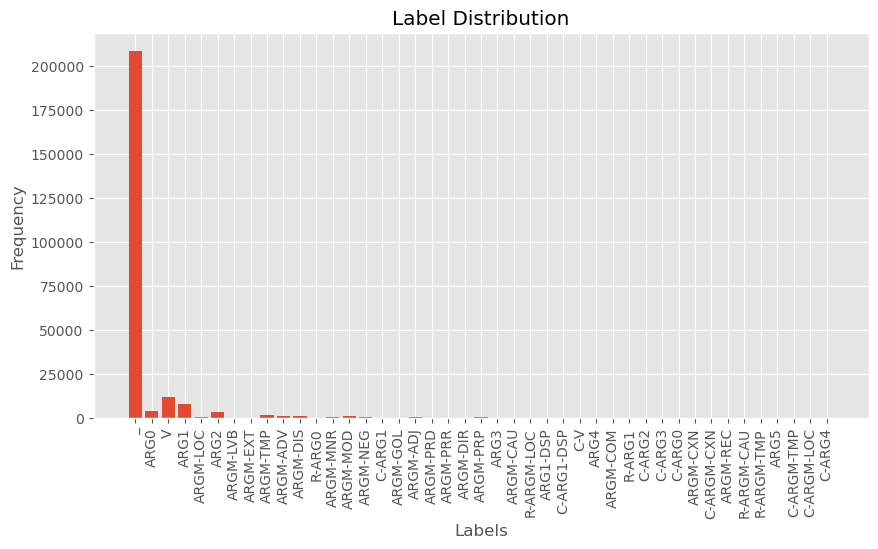

POS Tag distribution:
Counter({'NOUN': 41132, 'VERB': 28363, 'PUNCT': 27296, 'PRON': 22872, 'ADP': 21190, 'DET': 19808, 'AUX': 15401, 'ADJ': 15164, 'PROPN': 13978, 'ADV': 12766, 'CCONJ': 8051, 'PART': 6786, 'SCONJ': 4636, 'NUM': 3864, 'INTJ': 739, 'SYM': 666, 'X': 500})


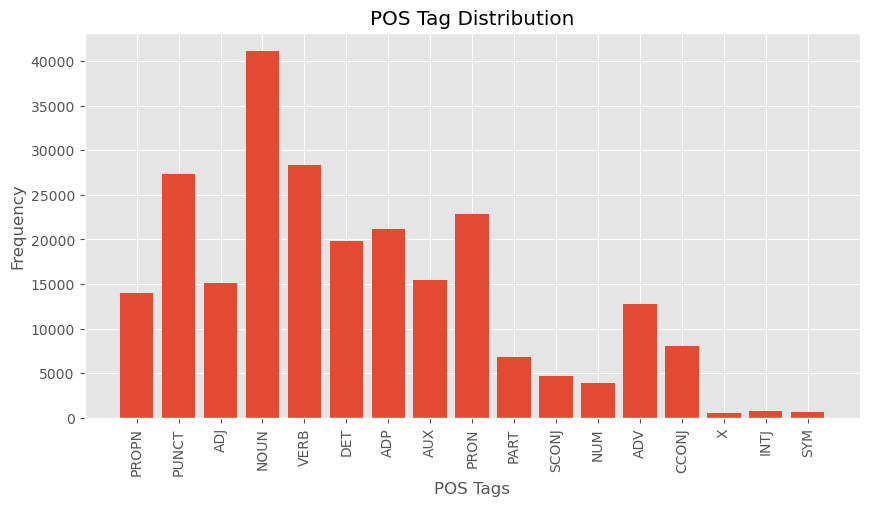

In [3]:
# 1. Basic statistics

# Total number of sentences
total_sentences = len(X)
print(f"Total number of sentences: {total_sentences}")

# Total number of words
total_words = sum(len(sentence) for sentence in X)
print(f"Total number of words: {total_words}")

# Average sentence length
average_sentence_length = total_words / total_sentences
print(f"Average sentence length (in words): {average_sentence_length:.2f}")

# 2. Label Distribution
label_counter = Counter(chain(*y))  # Flatten y and count labels
print(f"Label distribution:\n{label_counter}")

# Plot label distribution
plt.figure(figsize=(10, 5))
plt.bar(label_counter.keys(), label_counter.values())
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Label Distribution')
plt.xticks(rotation=90)
plt.show()

# 3. POS Tag Distribution
pos_counter = Counter(word[1] for sentence in X for word in sentence)
print(f"POS Tag distribution:\n{pos_counter}")

# Plot POS tag distribution
plt.figure(figsize=(10, 5))
plt.bar(pos_counter.keys(), pos_counter.values())
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.title('POS Tag Distribution')
plt.xticks(rotation=90)
plt.show()

## Approach
This code performs data exploration by calculating and visualizing basic statistics:

1. Basic Sentence Statistics:
    Counts total sentences (total_sentences), total words (total_words), and calculates the average sentence length (average_sentence_length).
2. Label Distribution:
    Flattens the label list (y) and counts the occurrence of each label using Counter. It then plots the distribution of labels using a bar chart.
3. POS Tag Distribution:
    Extracts part-of-speech (POS) tags from the sentences (X), counts their occurrences, and plots the distribution of POS tags using a bar chart.

Both label and POS distributions are visualized to show their frequency in the dataset.

## Output interpretation
1. Sentence Statistics:
- There are 13,628 sentences in total.
- These sentences contain 243,212 words, resulting in an average sentence length of 17.85 words.

2. Label Distribution:
- The most frequent label is '_' (representing no label), with 208,169 occurrences. This suggests many tokens in the dataset do not have specific semantic roles.
- Key semantic roles:
- 'V' (verb/predicate) has 12,093 occurrences.
- 'ARG1' (usually the object) appears 7,954 times.
- 'ARG0' (usually the subject/agent) appears 3,960 times.
- Less frequent labels such as 'ARG2', 'ARGM-TMP' (temporal), and others are present in smaller quantities.
- The long tail of the distribution includes many rare labels, with some appearing only once or a few times (e.g., 'C-ARG4', 'ARG5', 'ARGM-CXN').

3. POS Tag Distribution:
- The dataset is dominated by nouns (41,132), followed by verbs (28,363), punctuation (27,296), and pronouns (22,872).
- Other tags, like adjectives (15,164) and adpositions (21,190) (prepositions and conjunctions), are also common.
- Rare tags such as INTJ (interjections) and SYM (symbols) appear infrequently.

4. Visualization:
- The POS distribution chart shows the prominence of nouns, verbs, and punctuation.
- The label distribution chart highlights that the majority of tokens are unlabeled ('_'), with a significant number of verbs ('V') and core arguments ('ARG0', 'ARG1'), while many other labels are rare.

In [4]:
# Function to treat missing values in the parsed data
def treat_missing_values(sentence, label):
    treated_sentence = []
    treated_labels = []

    for word_info, srl_label in zip(sentence, label):
        lemma, pos, head, deprel, predicate = word_info

        # Treat missing lemma: replace with "<UNK>"
        if lemma == "_" or lemma == "" or lemma is None:
            lemma = "<UNK>"

        # Treat missing predicate: replace "_" with None
        if predicate == "_" or predicate == "" or predicate is None:
            predicate = None  # Optionally, you can leave it as "_"

        # Treat missing SRL label: replace "_" with "O"
        if srl_label == "_" or srl_label == "" or srl_label is None:
            srl_label = "O"

        # Reconstruct the treated word info and label
        treated_sentence.append((lemma, pos, head, deprel, predicate))
        treated_labels.append(srl_label)

    return treated_sentence, treated_labels

# Function to parse and treat CoNLL-U format data from a list of file paths
def parse_and_treat_conllu(file_paths):
    all_sentences = []
    all_labels = []

    for file_path in file_paths:
        sentences = []
        labels = []
        sentence = []
        label = []

        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('#') or line.strip() == "":
                    # Only append if sentence and label lengths match
                    if sentence and label and len(sentence) == len(label):
                        # Treat missing values before appending
                        treated_sentence, treated_labels = treat_missing_values(sentence, label)
                        sentences.append(treated_sentence)
                        labels.append(treated_labels)
                    sentence = []
                    label = []
                else:
                    parts = line.strip().split('\t')
                    if len(parts) >= 12:
                        lemma = parts[1]
                        pos = parts[3]
                        head = parts[6]
                        deprel = parts[7]
                        predicate = parts[10]
                        srl_label = parts[11]
                        sentence.append((lemma, pos, head, deprel, predicate))
                        label.append(srl_label)

        # Append last sentence and label if they match
        if sentence and label and len(sentence) == len(label):
            treated_sentence, treated_labels = treat_missing_values(sentence, label)
            sentences.append(treated_sentence)
            labels.append(treated_labels)

        # Add to the main lists
        all_sentences.extend(sentences)
        all_labels.extend(labels)

    return all_sentences, all_labels

# List of file paths to read
file_paths = [
    'en_ewt-up-train.conllu',
    'en_ewt-up-dev.conllu',
    'en_ewt-up-test-no-labels.conllu'
]

# Parse and treat the files for missing values
X, y = parse_and_treat_conllu(file_paths)

# Print the first treated parsed sentence and label for verification
print(f"First treated sentence: {X[0]}")
print(f"First treated labels: {y[0]}")

# Check if the lengths of all sentences match with labels after treatment
def check_consistency(X, y):
    for i in range(len(X)):
        if len(X[i]) != len(y[i]):
            print(f"Mismatch in sentence {i}: X length = {len(X[i])}, y length = {len(y[i])}")

# Run consistency check
check_consistency(X, y)

First treated sentence: [('Al', 'PROPN', '0', 'root', None), ('-', 'PUNCT', '1', 'punct', None), ('Zaman', 'PROPN', '1', 'flat', None), (':', 'PUNCT', '1', 'punct', None), ('American', 'ADJ', '6', 'amod', None), ('forces', 'NOUN', '7', 'nsubj', None), ('killed', 'VERB', '1', 'parataxis', 'kill.01'), ('Shaikh', 'PROPN', '7', 'obj', None), ('Abdullah', 'PROPN', '8', 'flat', None), ('al', 'PROPN', '8', 'flat', None), ('-', 'PUNCT', '8', 'punct', None), ('Ani', 'PROPN', '8', 'flat', None), (',', 'PUNCT', '8', 'punct', None), ('the', 'DET', '15', 'det', None), ('preacher', 'NOUN', '8', 'appos', None), ('at', 'ADP', '18', 'case', None), ('the', 'DET', '18', 'det', None), ('mosque', 'NOUN', '7', 'obl', None), ('in', 'ADP', '21', 'case', None), ('the', 'DET', '21', 'det', None), ('town', 'NOUN', '18', 'nmod', None), ('of', 'ADP', '23', 'case', None), ('Qaim', 'PROPN', '21', 'nmod', None), (',', 'PUNCT', '21', 'punct', None), ('near', 'ADP', '28', 'case', None), ('the', 'DET', '28', 'det', None

## Approach

The code performs the following key tasks:

1. **Missing Value Treatment**:
   - **Lemma**: Replaces missing or invalid lemma values (`_`, `""`, or `None`) with `"<UNK>"`.
   - **Predicate**: Replaces missing predicates with `None`.
   - **SRL Label**: Replaces missing semantic role labels (`_`) with `"O"` (indicating no role).

2. **File Parsing**:
   - Parses CoNLL-U formatted files, extracts sentence data (`lemma`, `pos`, `head`, `deprel`, `predicate`), and their corresponding SRL labels.
   - For each sentence-label pair, treats missing values before appending to the overall list of sentences and labels.

3. **Consistency Check**:
   - After parsing and treatment, ensures each sentence has a corresponding label of the same length.

4. **Final Output**:
   - The treated sentences and labels are stored in lists (`X`, `y`), ready for further processing or evaluation. The first sentence and labels are printed for verification.
   
## Output Explanation

- **First Treated Sentence**:
  - Parsed sentence with each word represented by its linguistic features:
    - **Lemma**: The word itself (e.g., 'Al', 'killed').
    - **POS Tag**: Part of speech (e.g., 'PROPN', 'VERB').
    - **Head**: Syntactic head of the word.
    - **DepRel**: Dependency relation (e.g., 'root', 'nsubj').
    - **Predicate**: `None` replaces missing predicates.

- **First Treated Labels**:
  - Corresponding labels for each word in the sentence.
  - **O** for words without a role, specific SRL labels like **ARG0** (agent) and **V** (verb).

## 2.  Feature Design

In [5]:
def word2features(sentence, i):
    word = sentence[i][0]  # Lemma
    pos = sentence[i][1]  # POS Tag
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],  # Last 3 characters
        'word[-2:]': word[-2:],  # Last 2 characters
        'word[:3]': word[:3],    # First 3 characters (prefix)
        'word[:2]': word[:2],    # First 2 characters (prefix)
        'word.isupper()': word.isupper(),  # Is the word in uppercase?
        'word.istitle()': word.istitle(),  # Is the word title-cased?
        'word.isdigit()': word.isdigit(),  # Is the word a digit?
        'pos': pos,
        'pos[:2]': pos[:2],  # First 2 characters of POS
        'word.shape': ''.join(['X' if c.isupper() else 'x' for c in word]),  # Word shape
    }

    # Adding previous word features
    if i > 0:
        prev_word = sentence[i - 1][0]
        prev_pos = sentence[i - 1][1]
        features.update({
            'prev.word.lower()': prev_word.lower(),
            'prev.word.isupper()': prev_word.isupper(),
            'prev.pos': prev_pos,
            'prev.pos[:2]': prev_pos[:2],
        })
    else:
        features['BOS'] = True  # Beginning of the sentence

    # Adding next word features
    if i < len(sentence) - 1:
        next_word = sentence[i + 1][0]
        next_pos = sentence[i + 1][1]
        features.update({
            'next.word.lower()': next_word.lower(),
            'next.word.isupper()': next_word.isupper(),
            'next.pos': next_pos,
            'next.pos[:2]': next_pos[:2],
        })
    else:
        features['EOS'] = True  # End of the sentence

    # Add head and dependency relation features if available
    if len(sentence[i]) >= 4:
        features.update({
            'head': sentence[i][2],  # Syntactic head
            'deprel': sentence[i][3],  # Dependency relation
        })

    # Add predicate features
    if len(sentence[i]) >= 5:
        features['predicate'] = sentence[i][4]  # Predicate
        features['is_predicate'] = sentence[i][4] != '_'

    return features


def extract_features(sentences, labels):
    X, y = [], []
    for sentence, label_seq in zip(sentences, labels):
        X.append([word2features(sentence, i) for i in range(len(sentence))])
        y.append(label_seq)
    return X, y

# Parse the files (make sure to run the `parse_conllu` function first)
X_sentences, y_labels = parse_conllu(file_paths)

# Extract features and labels
X_train, y_train = extract_features(X_sentences, y_labels)

# Print example features for the first word in the first sentence
print(f"Features of the first word in the first sentence: {X_train[0][0]}")
print(f"Labels of the first sentence: {y_train[0]}")

Features of the first word in the first sentence: {'bias': 1.0, 'word.lower()': 'al', 'word[-3:]': 'Al', 'word[-2:]': 'Al', 'word[:3]': 'Al', 'word[:2]': 'Al', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'pos': 'PROPN', 'pos[:2]': 'PR', 'word.shape': 'Xx', 'BOS': True, 'next.word.lower()': '-', 'next.word.isupper()': False, 'next.pos': 'PUNCT', 'next.pos[:2]': 'PU', 'head': '0', 'deprel': 'root', 'predicate': '_', 'is_predicate': False}
Labels of the first sentence: ['_', '_', '_', '_', '_', 'ARG0', 'V', 'ARG1', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'ARGM-LOC', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']


## Code Explanation

### `word2features` Function:
- Generates features for each word in a sentence based on:
  - **Lemma**: Lowercased word, prefixes, suffixes, word shape, title case, etc.
  - **POS Tag**: Full and first 2 characters of part-of-speech tag.
  - **Contextual Features**: Previous and next word features like lemma, uppercase check, and POS tag.
  - **Head and Dependency Relation**: Syntactic features if available.
  - **Predicate**: Predicate presence is checked and added if applicable.

- Special flags for the start and end of sentences (BOS/EOS).

### `extract_features` Function:
- Iterates over sentences and labels to extract features for each word using `word2features`.
- Stores features and labels in `X` (features) and `y` (labels) lists for training.

### Example:
- Parses CoNLL-U files, extracts features, and prints the features for the first word of the first sentence.

## Output Explanation

### Features of the First Word in the First Sentence:
- **Word**: 'Al' (lowercased as 'al')
  - **Suffixes/Prefixes**: Last 3 characters ('Al'), first 3 characters ('Al').
  - **Word Properties**: 
    - Not fully uppercase.
    - Title-cased.
    - Not a digit.
  - **POS Tag**: 'PROPN' (proper noun) and its first 2 characters 'PR'.
  - **Word Shape**: 'Xx' (uppercase followed by lowercase).
  - **Contextual Features**:
    - **BOS**: Beginning of sentence flag is True.
    - Next word features: 'next.word.lower()' is '-', 'next.pos' is 'PUNCT' (punctuation).
  - **Syntactic Features**: 
    - **Head**: '0' (root position in sentence).
    - **Dependency Relation**: 'root'.
  - **Predicate**: None ('_'), and it is not a predicate.

### Labels of the First Sentence:
- Labels include semantic role labels like 'ARG0', 'V', 'ARG1', and placeholders ('_') for non-predicate words. For example, 'ARG0' refers to an agent role, and 'V' refers to a verb.

## Preparing Data for testing and training

In [6]:
# Function to prepare the data for training and testing
def prepare_data_for_training(sentences, labels):
    X, y = [], []
    
    # For each sentence, extract the features and corresponding labels
    for sentence, label_seq in zip(sentences, labels):
        X.append([word2features(sentence, i) for i in range(len(sentence))])
        y.append(label_seq)
    
    return X, y

# Prepare the features (X) and labels (y) from the parsed sentences and labels
X, y = prepare_data_for_training(X_sentences, y_labels)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the sizes of the splits
print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")

# Print the first training sample for verification
print(f"First training sample features: {X_train[0]}")
print(f"First training sample labels: {y_train[0]}")

Number of training samples: 10902
Number of testing samples: 2726
First training sample features: [{'bias': 1.0, 'word.lower()': 'an', 'word[-3:]': 'An', 'word[-2:]': 'An', 'word[:3]': 'An', 'word[:2]': 'An', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'pos': 'DET', 'pos[:2]': 'DE', 'word.shape': 'Xx', 'BOS': True, 'next.word.lower()': 'embarrassment', 'next.word.isupper()': False, 'next.pos': 'NOUN', 'next.pos[:2]': 'NO', 'head': '2', 'deprel': 'det', 'predicate': '_', 'is_predicate': False}, {'bias': 1.0, 'word.lower()': 'embarrassment', 'word[-3:]': 'ent', 'word[-2:]': 'nt', 'word[:3]': 'emb', 'word[:2]': 'em', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'pos': 'NOUN', 'pos[:2]': 'NO', 'word.shape': 'xxxxxxxxxxxxx', 'prev.word.lower()': 'an', 'prev.word.isupper()': False, 'prev.pos': 'DET', 'prev.pos[:2]': 'DE', 'next.word.lower()': 'to', 'next.word.isupper()': False, 'next.pos': 'ADP', 'next.pos[:2]': 'AD', 'head': '0', '

## Code Explanation

### Function: `prepare_data_for_training`
- **Purpose**: 
  - This function extracts word-level features for each sentence using `word2features` and pairs them with corresponding labels.
  - It returns a feature set (`X`) and label set (`y`).
  
### Data Preparation:
- **Feature and Label Extraction**: 
  - For each sentence in the dataset, features are extracted using `word2features` for every word, and corresponding labels are appended.
  
### Data Splitting:
- **Train-Test Split**:
  - The data is split into training and testing sets (80% for training, 20% for testing) using `train_test_split`.
  - The `random_state=42` ensures reproducibility.

### Output:
- **Size of Splits**:
  - Number of training and testing samples is printed to verify the split.
- **Sample Verification**:
  - The features and labels of the first training sample are printed to ensure correct preparation.
  
## Output Explanation

- **Training and Testing Split:**
  - Number of training samples: 10,902
  - Number of testing samples: 2,726
  
- **First Training Sample Features:**
  - The features of the first word "an" include attributes like:
    - Word shape, whether it’s uppercase, title-cased, or a digit.
    - POS tag and first two characters of the POS tag.
    - Features for the previous and next words such as "embarrassment" (next word) and "DET" (POS of previous word).
    - The dependency relation (`deprel`) and syntactic head (`head`).
    - Predicate information, with a bias term set to 1.0.
  
- **Labels:**
  - The corresponding label sequence for the sentence, including roles like `ARG0`, `V`, `ARGM-LOC`, and `_` for non-predicate elements.

## 3. Model development

In [7]:


# Train the CRF model using sklearn-crfsuite
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,  # Coefficient for L1 regularization
    c2=0.1,  # Coefficient for L2 regularization
    max_iterations=100
)

crf.fit(X_train, y_train)

# Predict on the test set
y_pred_crf = crf.predict(X_test)


In [8]:
# Evaluate the CRF model
print("CRF Classification Report:")
print(metrics.flat_classification_report(y_test, y_pred_crf, labels=crf.classes_))

CRF Classification Report:
              precision    recall  f1-score   support

           _       0.94      0.97      0.95     41196
           V       0.78      0.72      0.75      2417
        ARG1       0.61      0.52      0.56      1577
        ARG0       0.69      0.68      0.69       755
    ARGM-PRD       0.00      0.00      0.00        21
      R-ARG0       0.89      0.50      0.64        16
        ARG2       0.59      0.44      0.51       668
    ARGM-TMP       0.57      0.40      0.47       307
    ARGM-ADV       0.44      0.25      0.32       199
    ARGM-LOC       0.25      0.16      0.19        82
    ARGM-MOD       0.83      0.77      0.80       210
    ARGM-DIS       0.71      0.57      0.63       168
    ARGM-DIR       0.36      0.38      0.37        21
    ARGM-NEG       0.72      0.72      0.72        68
    ARGM-MNR       0.47      0.14      0.21        59
    ARGM-CAU       0.00      0.00      0.00        36
        ARG4       0.22      0.10      0.13        21


/Users/bhavna_balakrishnan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bhavna_balakrishnan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bhavna_balakrishnan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

## Code Explanation

- **CRF Model Training:**
  - A CRF (Conditional Random Field) model is initialized using `sklearn-crfsuite`.
  - It uses the **L-BFGS** algorithm with L1 (`c1=0.1`) and L2 (`c2=0.1`) regularization coefficients.
  - The training process is run for a maximum of 100 iterations (`max_iterations=100`).

- **Model Fitting:**
  - The model is trained using the `fit` method on the training data (`X_train`, `y_train`), which includes the extracted features and labels.

- **Prediction:**
  - After training, the model predicts labels on the test set (`X_test`) using the `predict` method, storing the results in `y_pred_crf`.
  
### CRF Classification Report Summary:

- **Micro-average**: 
  - Precision, recall, and F1-score: **0.91**
  - High overall accuracy across all labels.

- **Macro-average**:
  - Precision: **0.31**
  - Recall: **0.22**
  - F1-score: **0.24**
  - Indicates difficulty with rare classes.

- **Top performing labels**:
  - `'_'`: F1-score: **0.95**
  - `'V'`: F1-score: **0.75**
  - `'ARG1'` and `'ARG0'`: F1-scores: **0.56** and **0.69**

- **Poor performance**:
  - Classes like `'ARGM-PRD'`, `'ARG4'` have near-zero F1-scores due to lack of predictions.

Overall, the model performs well for frequent labels but struggles with rare ones.

## Hyperparameter Tuning

In [9]:


# Define the CRF model
hyper_crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100
)

# Define the hyperparameter grid
param_grid = {
    'c1': [0.1, 0.2],  # Values for L1 regularization
    'c2': [0.01, 0.05]  # Values for L2 regularization
}

# Define the scoring method using weighted F1 score
scorer = make_scorer(metrics.flat_f1_score, average='weighted')

# Set up GridSearchCV
grid_search = GridSearchCV(hyper_crf, param_grid, 
                           cv=3,  # 3-fold cross-validation
                           verbose=1, 
                           n_jobs=-1,  # Use all CPU cores
                           scoring=scorer)  # Using F1 score for evaluation

# Perform hyperparameter search
grid_search.fit(X_train, y_train)

# Output the best hyperparameters and the best score
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best F1 score during tuning: {grid_search.best_score_}")

# Train a CRF model with the best parameters
best_crf = grid_search.best_estimator_

# Evaluate the best CRF model on the test set
y_pred = best_crf.predict(X_test)



Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best hyperparameters: {'c1': 0.2, 'c2': 0.05}
Best F1 score during tuning: 0.8988464520465976


### CRF Model with Hyperparameter Tuning

- **Model Definition**: 
  - A CRF model is defined using the `lbfgs` algorithm with a maximum of 100 iterations.
  
- **Hyperparameter Grid**: 
  - L1 regularization values (`c1`): [0.1, 0.2]
  - L2 regularization values (`c2`): [0.01, 0.05]

- **Scoring**: 
  - Weighted F1 score is used as the evaluation metric.

- **Grid Search Setup**: 
  - `GridSearchCV` is employed with 3-fold cross-validation and parallel processing (`n_jobs=-1`).

- **Hyperparameter Search**: 
  - `grid_search.fit()` is performed on the training data (`X_train`, `y_train`).

- **Results**: 
  - The best hyperparameters and best F1 score are printed.
  
- **Model Evaluation**: 
  - The best CRF model is retrained using the optimal parameters and evaluated on the test set (`X_test`).

In [10]:
# Print classification report for the tuned model
print("Classification Report for Tuned CRF Model:")
print(metrics.flat_classification_report(y_test, y_pred, labels=best_crf.classes_))

Classification Report for Tuned CRF Model:
              precision    recall  f1-score   support

           _       0.94      0.97      0.95     41196
           V       0.79      0.72      0.75      2417
        ARG1       0.62      0.52      0.57      1577
        ARG0       0.69      0.70      0.70       755
    ARGM-PRD       0.00      0.00      0.00        21
      R-ARG0       0.90      0.56      0.69        16
        ARG2       0.58      0.44      0.50       668
    ARGM-TMP       0.57      0.40      0.47       307
    ARGM-ADV       0.40      0.23      0.29       199
    ARGM-LOC       0.28      0.16      0.20        82
    ARGM-MOD       0.83      0.76      0.79       210
    ARGM-DIS       0.71      0.58      0.64       168
    ARGM-DIR       0.41      0.33      0.37        21
    ARGM-NEG       0.72      0.69      0.71        68
    ARGM-MNR       0.47      0.14      0.21        59
    ARGM-CAU       0.00      0.00      0.00        36
        ARG4       0.20      0.10     

/Users/bhavna_balakrishnan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bhavna_balakrishnan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bhavna_balakrishnan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

### Tuned CRF Model - Classification Report

- **Overall Performance**:
  - **Micro Average**: Precision = 0.91, Recall = 0.91, F1 = 0.91
  - **Macro Average**: Precision = 0.31, Recall = 0.22, F1 = 0.25
  - **Weighted Average**: Precision = 0.90, Recall = 0.91, F1 = 0.90

- **Key Observations**:
  - **High-Performing Labels**:
    - **_** (no role): Precision = 0.94, Recall = 0.97, F1 = 0.95
    - **V** (Verb): Precision = 0.79, Recall = 0.72, F1 = 0.75
    - **ARG0**: Precision = 0.69, Recall = 0.70, F1 = 0.70
  - **Low-Performing Labels**:
    - **ARGM-PRD**: Precision = 0.00, Recall = 0.00, F1 = 0.00
    - **ARG4**: Precision = 0.20, Recall = 0.10, F1 = 0.13
  - **ARG1**: Precision = 0.62, Recall = 0.52, F1 = 0.57
  
- **Label Discrepancies**:
  - Some labels, such as **C-ARG1**, **R-ARGM-TMP**, and **C-ARG3**, have extremely low or 0 scores due to sparse support in the test set.

## 4. Model evaluation

In [13]:
# Ensure hyperparameter-tuned CRF model is properly trained
if hasattr(grid_search, 'best_estimator_'):
    best_crf = grid_search.best_estimator_

    # 1. Evaluate the Default CRF Model (crf)
    y_pred_crf = crf.predict(X_test)
    macro_f1_crf = metrics.flat_f1_score(y_test, y_pred_crf, average='macro')
    print("Default CRF Model - Classification Report:")
    print(metrics.flat_classification_report(y_test, y_pred_crf, labels=crf.classes_))
    print(f"Default CRF Model - Macro-average F1 Score: {macro_f1_crf:.4f}")

    # 2. Evaluate the Hyperparameter-Tuned CRF Model (best_crf)
    y_pred_hyper_crf = best_crf.predict(X_test)
    macro_f1_hyper_crf = metrics.flat_f1_score(y_test, y_pred_hyper_crf, average='macro')
    print("\nTuned CRF Model - Classification Report:")
    print(metrics.flat_classification_report(y_test, y_pred_hyper_crf, labels=best_crf.classes_))
    print(f"Tuned CRF Model - Macro-average F1 Score: {macro_f1_hyper_crf:.4f}")

    # Compare the two models
    if macro_f1_hyper_crf > macro_f1_crf:
        print(f"\nThe hyperparameter-tuned CRF model performs better with a macro-average F1 score of {macro_f1_hyper_crf:.4f}")
    else:
        print(f"\nThe default CRF model performs better with a macro-average F1 score of {macro_f1_crf:.4f}")

else:
    print("Error: The hyper_crf model was not properly trained.")

Default CRF Model - Classification Report:


/Users/bhavna_balakrishnan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bhavna_balakrishnan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bhavna_balakrishnan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

              precision    recall  f1-score   support

           _       0.94      0.97      0.95     41196
           V       0.78      0.72      0.75      2417
        ARG1       0.61      0.52      0.56      1577
        ARG0       0.69      0.68      0.69       755
    ARGM-PRD       0.00      0.00      0.00        21
      R-ARG0       0.89      0.50      0.64        16
        ARG2       0.59      0.44      0.51       668
    ARGM-TMP       0.57      0.40      0.47       307
    ARGM-ADV       0.44      0.25      0.32       199
    ARGM-LOC       0.25      0.16      0.19        82
    ARGM-MOD       0.83      0.77      0.80       210
    ARGM-DIS       0.71      0.57      0.63       168
    ARGM-DIR       0.36      0.38      0.37        21
    ARGM-NEG       0.72      0.72      0.72        68
    ARGM-MNR       0.47      0.14      0.21        59
    ARGM-CAU       0.00      0.00      0.00        36
        ARG4       0.22      0.10      0.13        21
    ARGM-GOL       0.00    

/Users/bhavna_balakrishnan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bhavna_balakrishnan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           _       0.94      0.97      0.95     41196
           V       0.79      0.72      0.75      2417
        ARG1       0.62      0.52      0.57      1577
        ARG0       0.69      0.70      0.70       755
    ARGM-PRD       0.00      0.00      0.00        21
      R-ARG0       0.90      0.56      0.69        16
        ARG2       0.58      0.44      0.50       668
    ARGM-TMP       0.57      0.40      0.47       307
    ARGM-ADV       0.40      0.23      0.29       199
    ARGM-LOC       0.28      0.16      0.20        82
    ARGM-MOD       0.83      0.76      0.79       210
    ARGM-DIS       0.71      0.58      0.64       168
    ARGM-DIR       0.41      0.33      0.37        21
    ARGM-NEG       0.72      0.69      0.71        68
    ARGM-MNR       0.47      0.14      0.21        59
    ARGM-CAU       0.00      0.00      0.00        36
        ARG4       0.20      0.10      0.13        21
    ARGM-GOL       0.00    

/Users/bhavna_balakrishnan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bhavna_balakrishnan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bhavna_balakrishnan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

### CRF Model Evaluation and Comparison

1. **Default CRF Model Evaluation**:
   - Predictions are made using the default CRF model (`crf`).
   - The **macro-average F1 score** for the default model is computed.
   - The classification report for the default model is printed, showing precision, recall, and F1 score for each label.

2. **Hyperparameter-Tuned CRF Model Evaluation**:
   - If the hyperparameter tuning (`grid_search`) was successful, predictions are made using the best CRF model (`best_crf`).
   - The **macro-average F1 score** for the tuned model is computed.
   - The classification report for the tuned model is printed, similar to the default model's.

3. **Model Comparison**:
   - The macro-average F1 scores of the two models are compared.
   - The model with the higher macro-average F1 score is identified as the better-performing model.

4. **Error Handling**:
   - If the hyperparameter tuning was not successful, an error message is displayed.

## 5. Result Analysis

### CRF Model Performance Summary

1. **Default CRF Model**:
   - **Macro-average F1 Score**: 0.3072
   - High precision and recall for major labels like `_` and `V`.
   - Low scores for rare labels like `ARGM-PRD`, `ARGM-CAU`, and `ARGM-GOL` due to ill-defined metrics when no samples were predicted.

2. **Tuned CRF Model**:
   - **Macro-average F1 Score**: 0.3114
   - Slight improvement in performance after hyperparameter tuning, especially for major labels.
   - Similar issues with ill-defined metrics for rare labels.

3. **Conclusion**:
   - The hyperparameter-tuned CRF model performs better with a macro-average F1 score of **0.3114** compared to the default model's score of **0.3072**.
   
## Saving best predictions

In [23]:
# ID
id_column = [i for i in range(len(y_pred))]  
# Create a DataFrame with two columns: id and predicted labels
output_df = pd.DataFrame({
    'id': id_column,
    'predicted_labels': [' '.join(labels) for labels in y_pred]  # Join predicted labels for each sentence
})

# Save the DataFrame to a CSV file
output_df.to_csv('A2_Task_2_pred_labels.csv', index=False)

print("Predictions saved to A2_Task_2_pred_labels.csv")

Predictions saved to A2_Task_2_pred_labels.csv
